In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(15,8)})

path_to_catalog=r'C:\Users\kgrzebien\Desktop\python_tasks\kupony\zamawiajace\\'


In [140]:
def func_read_data(path, file):
    df=pd.read_csv(path+file+'.csv',
              encoding='Cp1250',
              sep="|")
    if 'IS_DELETED' in df.columns:
        df=df.loc[df['IS_DELETED']=='N']
    return df


def func_str_to_float(s):
    s=s.astype(str)
    s=s.apply(lambda x: x.replace(',','.'))
    s=s.astype(float)
    return s

def func_date(df, min_date, col_date):
    df[col_date]=pd.to_datetime(df[col_date], format='%y/%m/%d')
    
    df=df.loc[df[col_date]>=np.datetime64(min_date)].reset_index().drop('index', axis=1)
    df['year']=df[col_date].apply(lambda x: x.year)
    df['month']=df[col_date].apply(lambda x: x.month)
    df['day_of_year']=df[col_date].apply(lambda x: x.timetuple().tm_yday)
    df['week']=df[col_date].apply(lambda x: x.isocalendar()[1])
    df['week_day']=df[col_date].apply(lambda x: x.isocalendar()[2])
    df['year_month']=df['year'].astype(str)+'-'+df['month'].astype(str)+'-'+'01'
    df['year_month']=df['year_month'].apply(lambda x: x[:5]+'0'+x[5:] if len(x)==9 else x)
    df['year_month']=pd.to_datetime(df['year_month'], format='%Y-%m-%d')
    df['year_week']=df['year'].astype(str)+'--'+df['week'].astype(str)
    df['year_week']=df['year_week'].apply(lambda x: x[:6]+'0'+x[6:] if len(x)==7 else x)
    df['year_day']=df['year'].astype(str)+'--'+df['day_of_year'].astype(str)
    df['year_day']=df['year_day'].apply(lambda x: x[:6]+'0'+x[6:] if len(x)<9 else x)
    
    return df

def func_add_name_workers(df, name_of_file_with_workers):
    df_pracownicy=pd.read_excel(name_of_file_with_workers)
    df_pracownicy['NUMER']=df_pracownicy['NUMER']#.astype(str)
    df_pracownicy=df_pracownicy.rename(columns={'PELNANAZWA':'NAZWISKO'})
    df_pracownicy['NAZWISKO']=df_pracownicy['NAZWISKO'].apply(lambda x: x.split(' ')[0][0]+'. '+x.split(' ')[1] if len(x.split(' '))>1 else x)
    df=df.merge(df_pracownicy, how='left', left_on='KOD_OPER', right_on='NUMER')
    df=df.drop('NUMER', axis=1)
    return df

def func_typ_dokumentu(df):
    df['TYP_DOKUM']=df['TYP_DOKUM'].apply(lambda x: x if x=='M' else 'V')
    return df

In [48]:
def func_read_rcp(df_ewid_rcp,
                  df_zad_rcp):
    df_ewid_rcp=func_date_rcp(df_ewid_rcp)
    df_rcp=df_ewid_rcp[['ID_ZAD','DATA','ROZ_DNIA','ZAK_DNIA','GODZ_PL','DATA_ROZ','GODZ_ROZ','DATA_ZAK','GODZ_ZAK','KOD_OPER', 'date_start', 'date_finish']].\
                merge(df_zad_rcp[['ID_ZAD','ZADANIE']].drop_duplicates(),
                      how='left', on='ID_ZAD')
    
    return df_rcp
    
def func_date_rcp(df):
    df=df.loc[df['GODZ_ROZ']!=' '].loc[df['GODZ_ZAK']!=' '].reset_index().drop('index', axis=1)
    df['date_start']=df['DATA']+' '+df['GODZ_ROZ']
    df['date_start']=pd.to_datetime(df['date_start'], format='%y/%m/%d %H:%M:%S')
    df['date_start']=df['date_start'].dt.floor('Min')
    df['date_finish']=df['DATA']+' '+df['GODZ_ZAK']
    df['date_finish']=pd.to_datetime(df['date_finish'], format='%y/%m/%d %H:%M:%S')
    df['date_finish']=df['date_finish'].dt.floor('Min')
    df['DATA']=pd.to_datetime(df['DATA'], format='%y/%m/%d')
    return df

df_grup_rcp=func_read_data('../../RCP_tables/',
                           'GRUP_RCP')
df_zad_rcp=func_read_data('../../RCP_tables/',
                           'ZAD_RCP')
df_ewid_rcp=func_read_data('../../RCP_tables/',
                           'EWID_RCP')

df_rcp=func_read_rcp(df_ewid_rcp, df_zad_rcp)
df_rcp=func_add_name_workers(df_rcp, '../../pracownicy.xlsx')

In [137]:
def func_minutes_in_work_day_rcp(df, tnaca1_numer):
    step=np.datetime64('2000-01-01 00:02:00')-np.datetime64('2000-01-01 00:01:00')
    
    df_with_minutes=pd.DataFrame(columns=['NAZWISKO', 'DATA', 'ile_minut_czynnosc', 'ile_minut_dzien', 'procent_wykorzystania', 'zadanie'])
    
    for day in (df.loc[df['NAZWISKO']==tnaca1_numer]['DATA'].unique()):
        arr_time_day=np.array([], dtype='datetime64')
        arr_time_activity=np.array([], dtype='int')
        arr_zadanie=[]
        arr_zadanie_group=[]
        try:
            for i in (df.loc[df['NAZWISKO']==tnaca1_numer].loc[df['DATA']==day].index):
                arr_tmp=np.arange(df.loc[i,'date_start'],
                                  df.loc[i,'date_finish'],
                                 step)
                arr_time_day=np.append(arr_time_day, arr_tmp)
                arr_time_activity=np.append(arr_time_activity, [len(arr_tmp)])
                arr_zadanie=np.append(arr_zadanie, [df.loc[i,'ZADANIE']])

            if len(arr_time_day)==0:
                display(day)
            ile_minut_maksymalnie=(arr_time_day.max()-arr_time_day.min())/np.timedelta64(1,'m')+1
            for time_activity, zadanie in zip(arr_time_activity, arr_zadanie ):
                df_with_minutes=df_with_minutes.append({'NAZWISKO':tnaca1_numer,
                                                        'DATA':day,
                                                        'ile_minut_czynnosc':time_activity,
                                                        'ile_minut_dzien':ile_minut_maksymalnie,
                                                       'procent_wykorzystania':time_activity/ile_minut_maksymalnie*100, 
                                                        'zadanie':zadanie},
                                                       ignore_index=True)
        except:
            pass
        
    
    return df_with_minutes

In [138]:
df_with_minutes_rcp=pd.DataFrame()
#flaga=0
for oper in tqdm(arr_kupony_obsluga_nazwiska):
    try:
        if oper == 0:
            continue

        df_with_minutes_tmp=func_minutes_in_work_day_rcp(df_rcp,
                                                             oper)
        df_with_minutes_rcp=df_with_minutes_rcp.append(df_with_minutes_tmp,
                                                          ignore_index=True)
    except:
        print(oper)
        continue

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [04:32<00:00, 34.09s/it]


In [141]:
df_with_minutes_rcp=func_date(df_with_minutes_rcp, '2020-01-01', 'DATA')

In [121]:
df_zamowienia=func_read_data('../zamawiajace/',
                             'zamowienia')
df_zamowienia=func_date(df_zamowienia, '2020-01-01', 'Z_DNIA')
df_zamowienia=func_add_name_workers(df_zamowienia, '../../pracownicy.xlsx')
df_zamowienia=func_typ_dokumentu(df_zamowienia)
df_zamowienia['WARTOSC_B_N13']=func_str_to_float(df_zamowienia['WARTOSC_B_N13'])
df_zamowienia['WARTOSC_B_ZAMOW1']=func_str_to_float(df_zamowienia['WARTOSC_B_ZAMOW1'])
df_zamowienia['FAKTURA_KD']=df_zamowienia['FAKTURA_KD'].apply(lambda x: 'nie_pusta' if x!='' else 'pusta')

In [100]:
# for i in ['B. DURAJ','E. KUBIENIEC','I. PAŁOSZ','A. BUŁAWA']:
#     display(i, df_rcp.loc[df_rcp['NAZWISKO']==i].groupby('ZADANIE').agg({'DATA':'nunique'}))
arr_kupony_obsluga_nazwiska=df_rcp.loc[df_rcp['ZADANIE']=='KUPONY-OBSŁUGA']['NAZWISKO'].unique()
#arr_kupony_obsluga_nazwiska=np.delete(arr_kupony_obsluga_nazwiska, np.where(arr_kupony_obsluga_nazwiska=='E. KUBIENIEC'))
arr_kupony_obsluga_nazwiska

array(['M. PSZCZÓŁKA', 'I. PAŁOSZ', 'J. SEMIK', 'B. DURAJ',
       'E. KUBIENIEC', 'I. DRABEK', 'R. KASPEREK', 'A. BUŁAWA'],
      dtype=object)

In [122]:
df_zamowienia.loc[df_zamowienia.loc[df_zamowienia['NAZWISKO'].isin(arr_kupony_obsluga_nazwiska)].index, 'czy_z_kuponow']='tak'
df_zamowienia['czy_z_kuponow']=df_zamowienia['czy_z_kuponow'].fillna('nie')

In [102]:
tmp=df_zamowienia.groupby(['czy_z_kuponow']).agg({'FAKTURA':'nunique'})
tmp['proc']=tmp['FAKTURA']/tmp['FAKTURA'].sum()*100
tmp

,FAKTURA,proc
czy_z_kuponow,,
nie,110219,67.487356
tak,53099,32.512644


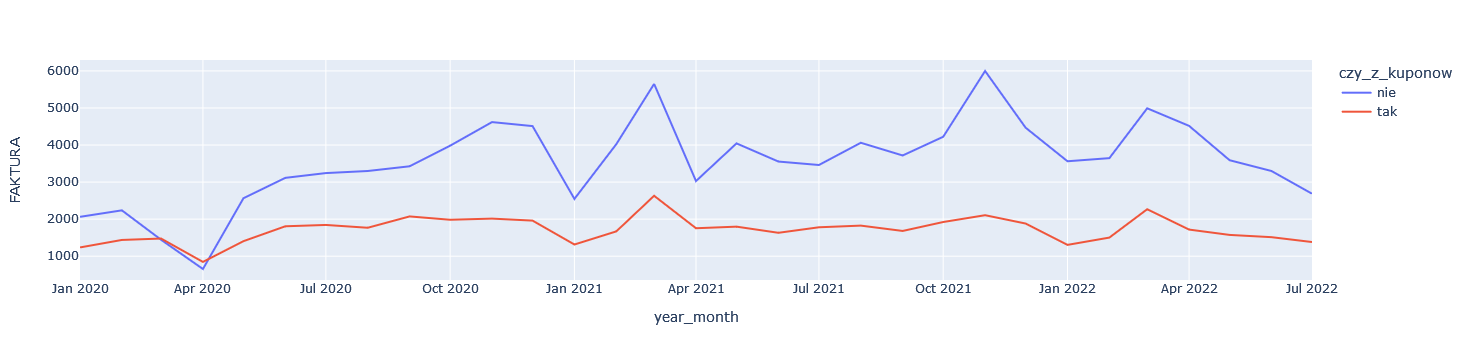

In [83]:
tmp=df_zamowienia.groupby(['czy_z_kuponow','year_month']).agg({'FAKTURA':'nunique',
                                                          'NAZWISKO':'nunique'}).reset_index()
px.line(tmp,
      x='year_month',
      y='FAKTURA',
      color='czy_z_kuponow')

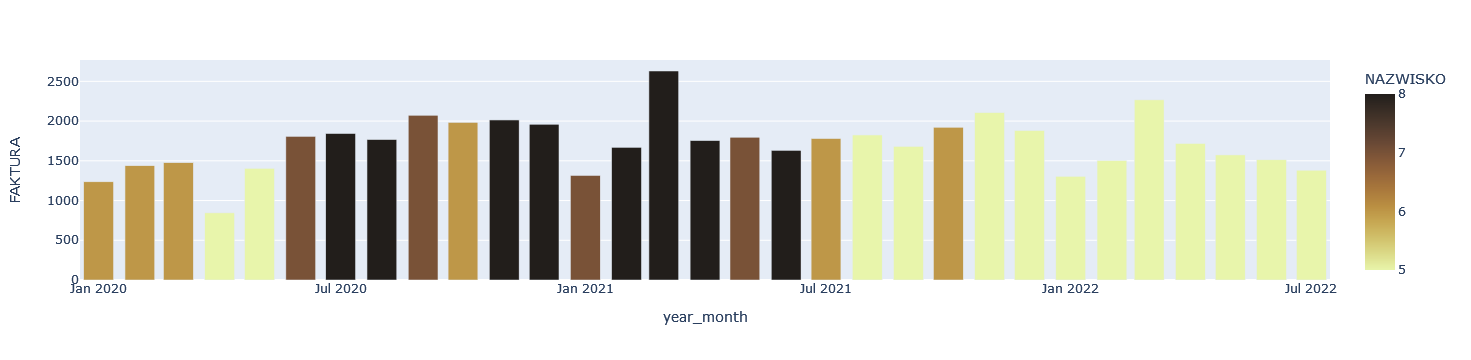

In [86]:
tmp=df_zamowienia.groupby(['czy_z_kuponow','year_month']).agg({'FAKTURA':'nunique',
                                                          'NAZWISKO':'nunique'}).reset_index()
px.bar(tmp.loc[tmp['czy_z_kuponow']=='tak'],
      x='year_month',
      y='FAKTURA',
      color='NAZWISKO',
      color_continuous_scale='turbid')

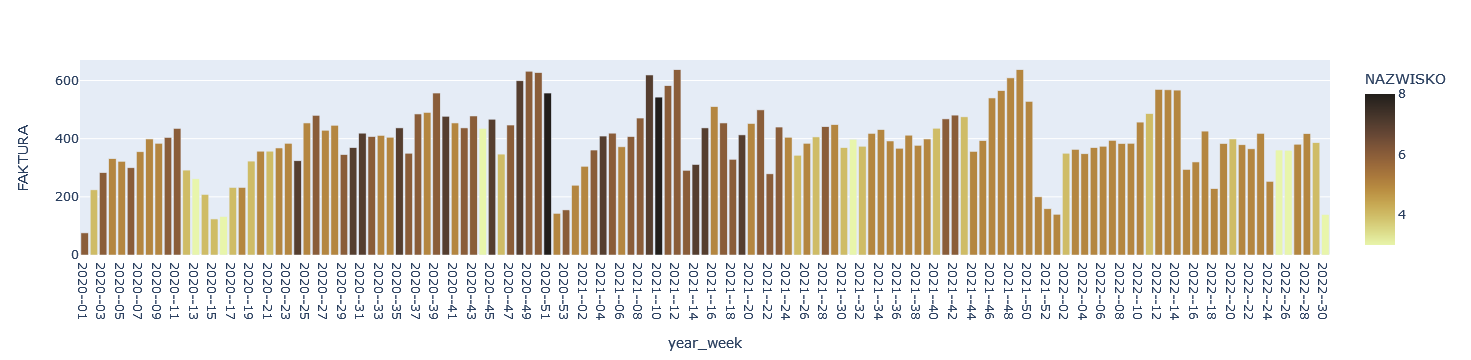

In [88]:
tmp=df_zamowienia.groupby(['czy_z_kuponow','year_week']).agg({'FAKTURA':'nunique',
                                                          'NAZWISKO':'nunique'}).reset_index()
px.bar(tmp.loc[tmp['czy_z_kuponow']=='tak'],
      x='year_week',
      y='FAKTURA',
      color='NAZWISKO',
      color_continuous_scale='turbid')

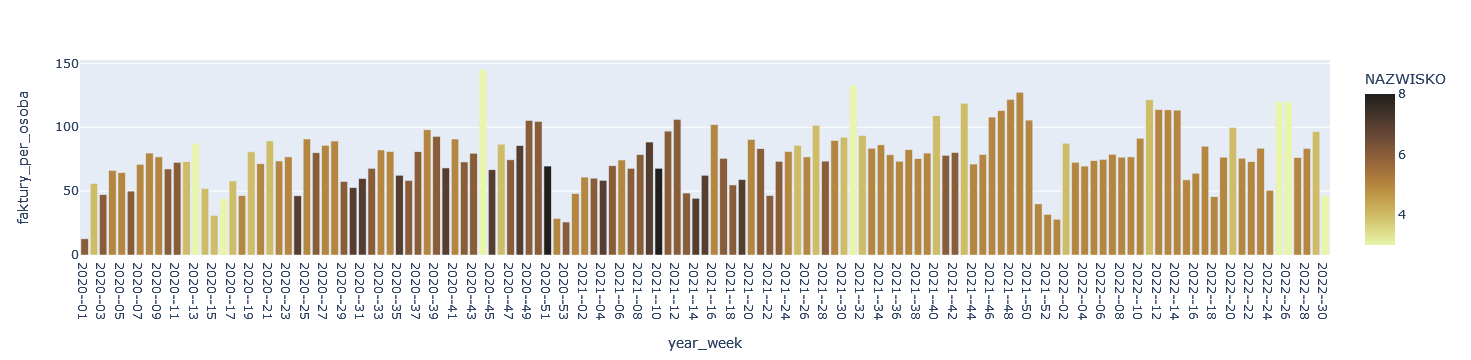

In [110]:
tmp=df_zamowienia.groupby(['czy_z_kuponow','year_week']).agg({'FAKTURA':'nunique',
                                                          'NAZWISKO':'nunique'}).reset_index()
tmp['faktury_per_osoba']=tmp['FAKTURA']/tmp['NAZWISKO']
px.bar(tmp.loc[tmp['czy_z_kuponow']=='tak'],
      x='year_week',
      y='faktury_per_osoba',
      color='NAZWISKO',
      color_continuous_scale='turbid')

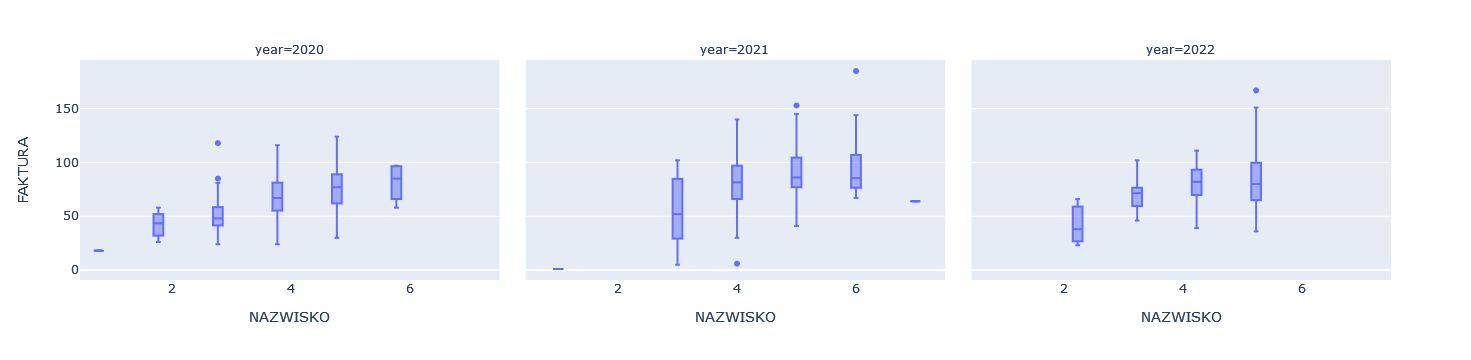

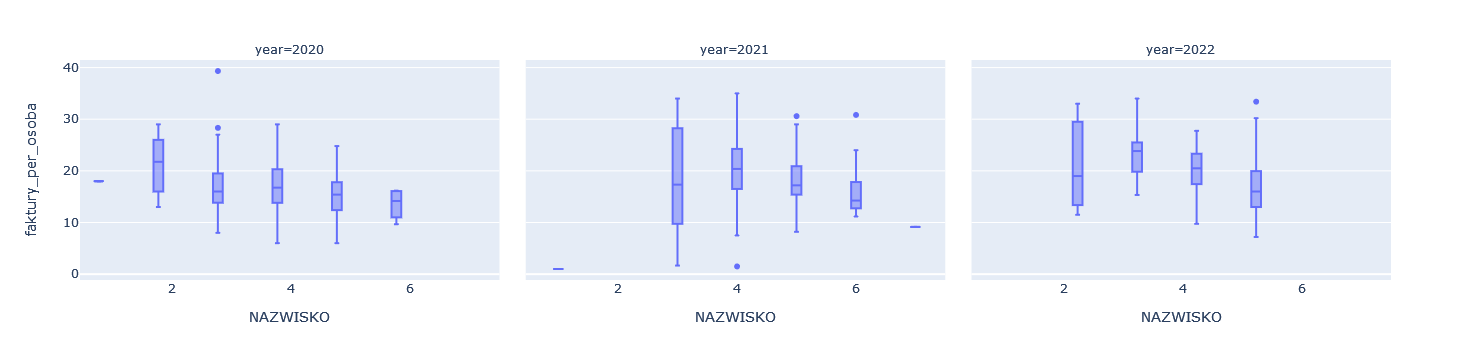

FAKTURA  faktury_per_osoba
year NAZWISKO                            
2020 1            18.0          18.000000
     2            43.5          21.750000
     3            48.0          16.000000
     4            67.0          16.750000
     5            77.0          15.400000
     6            85.0          14.166667
2021 1             1.0           1.000000
     3            52.0          17.333333
     4            81.5          20.375000
     5            86.0          17.200000
     6            85.5          14.250000
     7            64.0           9.142857
2022 2            38.0          19.000000
     3            71.5          23.833333
     4            82.0          20.500000
     5            80.0          16.000000

FAKTURA             faktury_per_osoba                      
year        2020  2021  2022              2020       2021       2022
NAZWISKO                                                            
1           18.0   1.0   NaN         18.000000   1.000000        NaN
2           43.5   NaN  38.0         21.750000        NaN  19.000000
3           48.0  52.0  71.5         16.000000  17.333333  23.833333
4           67.0  81.5  82.0         16.750000  20.375000  20.500000
5           77.0  86.0  80.0         15.400000  17.200000  16.000000
6           85.0  85.5   NaN         14.166667  14.250000        NaN
7            NaN  64.0   NaN               NaN   9.142857        NaN

In [177]:
tmp=df_zamowienia.groupby(['czy_z_kuponow','Z_DNIA','year','month']).agg({'FAKTURA':'nunique',
                                                          'NAZWISKO':'nunique'}).reset_index()
tmp['faktury_per_osoba']=tmp['FAKTURA']/tmp['NAZWISKO']

fig=px.box(tmp.loc[tmp['czy_z_kuponow']=='tak'].loc[tmp['month']<=6],
      x='NAZWISKO',
      y='FAKTURA',
          facet_col='year')
fig.show()
fig=px.box(tmp.loc[tmp['czy_z_kuponow']=='tak'].loc[tmp['month']<=6],
      x='NAZWISKO',
      y='faktury_per_osoba',
          facet_col='year')
fig.show()

display(tmp.loc[tmp['czy_z_kuponow']=='tak'].loc[tmp['month']<=6].groupby(['year','NAZWISKO']).agg({'FAKTURA':'median',
                                                   'faktury_per_osoba':'median'}).head(50))

display(tmp.loc[tmp['czy_z_kuponow']=='tak'].loc[tmp['month']<=6].groupby(['year','NAZWISKO']).agg({'FAKTURA':'median',
                                                                                               'faktury_per_osoba':'median'}).reset_index().\
        pivot(columns='year', index='NAZWISKO',values=['FAKTURA','faktury_per_osoba']))

In [ ]:
tmp=df_zamowienia.groupby(['czy_z_kuponow','Z_DNIA']).agg({'FAKTURA':'nunique',
                                                          'NAZWISKO':'nunique'}).reset_index()
tmp['faktury_per_osoba']=tmp['FAKTURA']/tmp['NAZWISKO']

In [159]:
def func_raport_pivot(df, year1, year2, month, df_with_minutes_rcp):
    df1=df.loc[df['year']==year1].loc[df['month'].isin(month)]
    df2=df.loc[df['year']==year2].loc[df['month'].isin(month)]
    df_with_minutes_rcp1=df_with_minutes_rcp.loc[df_with_minutes_rcp['year']==year1].loc[df_with_minutes_rcp['month'].isin(month)]
    df_with_minutes_rcp2=df_with_minutes_rcp.loc[df_with_minutes_rcp['year']==year2].loc[df_with_minutes_rcp['month'].isin(month)]
    
    # display(pd.pivot_table(df1,
    #               index='NAZWISKO',
    #               columns=col,
    #               aggfunc=np.sum()))
    df_tmp1=df1.groupby(['NAZWISKO','month']).agg({'FAKTURA':'nunique'})
    df_tmp1=df_tmp1.rename(columns={'FAKTURA':'FAKTURA_'+str(year1)})
    df_tmp2=df2.groupby(['NAZWISKO','month']).agg({'FAKTURA':'nunique'})
    df_tmp2=df_tmp2.rename(columns={'FAKTURA':'FAKTURA_'+str(year2)})
    df_tmp1_rcp=df_with_minutes_rcp1.loc[df_with_minutes_rcp1['zadanie']=='KUPONY-OBSŁUGA'].groupby(['NAZWISKO','month']).agg({'ile_minut_czynnosc':'sum'})
    df_tmp1_rcp=df_tmp1_rcp.rename(columns={'ile_minut_czynnosc':'ile_minut_czynnosc_'+str(year1)})
    df_tmp2_rcp=df_with_minutes_rcp2.loc[df_with_minutes_rcp2['zadanie']=='KUPONY-OBSŁUGA'].groupby(['NAZWISKO','month']).agg({'ile_minut_czynnosc':'sum'})
    df_tmp2_rcp=df_tmp2_rcp.rename(columns={'ile_minut_czynnosc':'ile_minut_czynnosc_'+str(year2)})
    
    display(df_tmp1.merge(df_tmp2,
                         how='outer',
                         left_index=True, right_index=True).\
                   merge(df_tmp1_rcp,
                                 how='left',
                                 left_index=True, right_index=True).\
                   merge(df_tmp2_rcp,
                                 how='left',
                                 left_index=True, right_index=True))
    return

In [160]:
func_raport_pivot(df_zamowienia.loc[df_zamowienia['czy_z_kuponow']=='tak'], 2021, 2022, [1,2,3,4,5,6], df_with_minutes_rcp)

FAKTURA_2021  FAKTURA_2022 ile_minut_czynnosc_2021  \
NAZWISKO     month                                                       
A. BUŁAWA    1               1.0         325.0                     NaN   
             2               1.0         411.0                     NaN   
             3               5.0         472.0                     NaN   
             4               2.0         288.0                     NaN   
             5               NaN         349.0                     NaN   
             6             412.0         441.0                    9113   
B. DURAJ     1             360.0         382.0                    9712   
             2             534.0         318.0                    8698   
             3             769.0         516.0                   12921   
             4             509.0         595.0                    9091   
             5             417.0         444.0                    9682   
             6             408.0         401.0                   10082   
E. KUBIENIEC 1             171.0          76.0                    9829   
             2             140.0         136.0                    8239   
             3             378.0         281.0                   10998   
             4             201.0         169.0                    9274   
             5             229.0         126.0                    9867   
             6             146.0         108.0                    6993   
I. DRABEK    2               3.0           NaN                     NaN   
             3               3.0           NaN                     NaN   
             4               4.0           NaN                     NaN   
             5              13.0           NaN                     NaN   
             6               3.0           NaN                     NaN   
I. PAŁOSZ    1             237.0           NaN                    9618   
             2             215.0           NaN                    7606   
             3             385.0           NaN                   11657   
             4             224.0           NaN                    9610   
             5             342.0           NaN                    8579   
             6              38.0           NaN                    1505   
J. SEMIK     1             298.0         378.0                    9583   
             2             424.0         473.0                    9422   
             3             648.0         620.0                   12717   
             4             461.0         367.0                    9117   
             5             488.0         373.0                    9592   
             6             457.0         453.0                    9535   
M. PSZCZÓŁKA 1             246.0           NaN                    9587   
             2             349.0           NaN                    9506   
             3             438.0           NaN                   12158   
             4             351.0           NaN                    9680   
             5             306.0           NaN                    9077   
             6              92.0           NaN                    3072   
R. KASPEREK  1               2.0         144.0                     NaN   
             2               3.0         164.0                     NaN   
             3               4.0         378.0                     NaN   
             4               2.0         299.0                     NaN   
             5               2.0         282.0                     NaN   
             6              75.0         110.0                    4169   

                   ile_minut_czynnosc_2022  
NAZWISKO     month                          
A. BUŁAWA    1                        9404  
             2                        9414  
             3                       10842  
             4                        7947  
             5                        8761  
             6                        9391  
B. DURAJ     1                   

In [128]:
df_zamowienia['FAKTURA'].nunique()

163318

In [152]:
df_rcp.loc[df_rcp['NAZWISKO']=='M. PSZCZÓŁKA'].sort_values(by='DATA')

,ID_ZAD,DATA,ROZ_DNIA,ZAK_DNIA,GODZ_PL,DATA_ROZ,GODZ_ROZ,DATA_ZAK,GODZ_ZAK,KOD_OPER,date_start,date_finish,ZADANIE,NAZWISKO
15591,ZP0000000023,2020-01-02,,,,20/01/29,06:00:00,20/01/29,14:00:00,506,2020-01-02 06:00:00,2020-01-02 14:00:00,URLOP,M. PSZCZÓŁKA
1689,ZP0000000952,2020-01-03,,,,20/01/03,07:30:25,20/01/03,16:00:35,506,2020-01-03 07:30:00,2020-01-03 16:00:00,KUPONY-OBSŁUGA,M. PSZCZÓŁKA
3984,ZP0000000952,2020-01-07,,,,20/01/07,07:30:44,20/01/07,16:30:16,506,2020-01-07 07:30:00,2020-01-07 16:30:00,KUPONY-OBSŁUGA,M. PSZCZÓŁKA
1201,ZP0000000952,2020-01-08,,,,20/01/08,07:37:17,20/01/08,15:59:54,506,2020-01-08 07:37:00,2020-01-08 15:59:00,KUPONY-OBSŁUGA,M. PSZCZÓŁKA
5684,ZP0000000952,2020-01-09,,,,20/01/09,07:42:21,20/01/09,16:29:56,506,2020-01-09 07:42:00,2020-01-09 16:29:00,KUPONY-OBSŁUGA,M. PSZCZÓŁKA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428394,ZP0000045804,2021-11-05,,,,21/11/05,06:00:00,21/11/05,14:00:00,506,2021-11-05 06:00:00,2021-11-05 14:00:00,ZASIŁEK,M. PSZCZÓŁKA
428395,ZP0000045804,2021-11-08,,,,21/11/08,06:00:00,21/11/08,14:00:00,506,2021-11-08 06:00:00,2021-11-08 14:00:00,ZASIŁEK,M. PSZCZÓŁKA
428396,ZP0000045804,2021-11-09,,,,21/11/09,06:00:00,21/11/09,14:00:00,506,2021-11-09 06:00:00,2021-11-09 14:00:00,ZASIŁEK,M. PSZCZÓŁKA
428397,ZP0000045804,2021-11-10,,,,21/11/10,06:00:00,21/11/10,14:00:00,506,2021-11-10 06:00:00,2021-11-10 14:00:00,ZASIŁEK,M. PSZCZÓŁKA


In [182]:
df_ewid_rcp.loc[df_ewid_rcp['KOD_OPER']==506].sort_values(by='DATA')

,RECNO,IS_DELETED,ID_ZAD,ID_ZAD_PG,ID_ZAD_IND,ID_ZAD_DOD,DATA,ROZ_DNIA,ZAK_DNIA,GODZ_PL,DATA_ROZ,GODZ_ROZ,DATA_ZAK,GODZ_ZAK,KOD_OPER,IE$0,IE$1,IE$2,IE$3,DATA_DNIA,IE$4,IE$5,KOD_GR_RCP,IL_JEDN,ID_DOK,NR_DOK,ID_POZ_DOK,OP_POZ_DOK
5910,20853,N,ZP0000000002,,,,17/05/04,08:00:00,,,12/01/01,,12/01/01,,506,,,,ZP0000000002 50630170504,17/05/04,ZP0000000002,50630170504,KUP,0,,,0,
6929,21073,N,ZP0000000003,,,,17/05/04,,16:31:04,,12/01/01,,12/01/01,,506,,,,ZP0000000003 50630170504,17/05/04,ZP0000000003,50630170504,KUP,0,,,0,
5767,21580,N,ZP0000000003,,,,17/05/05,,16:30:04,,12/01/01,,12/01/01,,506,,,,ZP0000000003 50630170505,17/05/05,ZP0000000003,50630170505,KUP,0,,,0,
6053,21200,N,ZP0000000002,,,,17/05/05,07:40:12,,,12/01/01,,12/01/01,,506,,,,ZP0000000002 50630170505,17/05/05,ZP0000000002,50630170505,KUP,0,,,0,
6722,22411,N,ZP0000000003,,,,17/05/08,,16:30:09,,12/01/01,,12/01/01,,506,,,,ZP0000000003 50630170508,17/05/08,ZP0000000003,50630170508,KUP,0,,,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961852,1457740,N,ZP0000045804,,,,21/11/05,,,,21/11/05,06:00:00,21/11/05,14:00:00,506,,,,ZP0000045804 50620211105,12/01/01,ZP0000045804,50620211105,KUP,0,,,0,
961853,1457741,N,ZP0000045804,,,,21/11/08,,,,21/11/08,06:00:00,21/11/08,14:00:00,506,,,,ZP0000045804 50620211108,12/01/01,ZP0000045804,50620211108,KUP,0,,,0,
961854,1457742,N,ZP0000045804,,,,21/11/09,,,,21/11/09,06:00:00,21/11/09,14:00:00,506,,,,ZP0000045804 50620211109,12/01/01,ZP0000045804,50620211109,KUP,0,,,0,
961855,1457743,N,ZP0000045804,,,,21/11/10,,,,21/11/10,06:00:00,21/11/10,14:00:00,506,,,,ZP0000045804 50620211110,12/01/01,ZP0000045804,50620211110,KUP,0,,,0,


In [186]:
df_zamowienia.loc[df_zamowienia['year']==2022].loc[df_zamowienia['month']==6].loc[df_zamowienia['KOD_OPER']==152]#.groupby(['RODZAJ']).agg({'FAKTURA':'nunique'})

,FAKTURA,Z_DNIA,KOD,KOD_OPER,FAKTURA_KD,OPIS,RODZAJ,TYP_DOKUM,WARTOSC_B_N13,WARTOSC_B_ZAMOW1,year,month,day_of_year,week,week_day,year_month,year_week,year_day,NAZWISKO,czy_z_kuponow
142325,ZO6000452927,2022-06-02,4062,152,nie_pusta,3,RZ,V,369.43,349.75,2022,6,153,22,4,2022-06-01,2022--22,2022--153,B. DURAJ,tak
142361,ZO6000453343,2022-06-03,4520,152,nie_pusta,0,RZ,V,189.30,189.30,2022,6,154,22,5,2022-06-01,2022--22,2022--154,B. DURAJ,tak
142572,ZO6000453667,2022-06-06,J93002,152,nie_pusta,0,RZ,V,577.61,577.61,2022,6,157,23,1,2022-06-01,2022--23,2022--157,B. DURAJ,tak
143404,ZO6000452747,2022-06-02,J93002,152,nie_pusta,21,RZ,V,466.79,466.79,2022,6,153,22,4,2022-06-01,2022--22,2022--153,B. DURAJ,tak
143405,ZO6000452758,2022-06-02,5038,152,nie_pusta,33,RZ,V,288.16,268.48,2022,6,153,22,4,2022-06-01,2022--22,2022--153,B. DURAJ,tak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163258,ZO6000454613,2022-06-08,3663,152,nie_pusta,3,RZ,V,294.46,274.78,2022,6,159,23,3,2022-06-01,2022--23,2022--159,B. DURAJ,tak
163280,ZO6000458464,2022-06-22,K72051,152,nie_pusta,7,RZ,V,412.05,392.37,2022,6,173,25,3,2022-06-01,2022--25,2022--173,B. DURAJ,tak
163298,ZO6000454637,2022-06-08,6089,152,nie_pusta,0,RZ,V,352.27,332.59,2022,6,159,23,3,2022-06-01,2022--23,2022--159,B. DURAJ,tak
163303,ZO6000460212,2022-06-28,90XXXX,152,nie_pusta,20,RZ,M,153.86,153.86,2022,6,179,26,2,2022-06-01,2022--26,2022--179,B. DURAJ,tak
